# Generalized Linear Models - Frequentists, Bayesian and Neural Network equivalent approaches

We will consider the logistic regression case of GLM's as a POC of different approaches to model estimation and prediction. We will consider the following cases

1. Estimation through frequentist framework (MLE)
2. Estimation through a deterministic neural network (equivalent to MLE)
3. Estimation through bayesian framework (MCMC)
4. Estimation through bayesian neural network (variational inference?)

To test the different frameworks, we will consider the following scenario:

- We have $n=10000$ observations. 
- For each, we have two covariates $X_1$ and $X_2$ we can observe. 
- We observe $Y$ a binary variable that takes the values of 1 and 0

Under this setup, we see $Y$ is a Bernoulli variable. We are interested in modelling $p_i$ the probability of success (and the expected value $E[Y]$). For this, we follo\hat{p}GLM convention and assume that



$$\pi_i = g(p_i) = \beta_0 + X_1 \beta_1 + X_ 2\beta_2$$

Under this scenario

$$Y \backsim Ber(g^{-1}(\pi_i))$$

We assume $\beta_0 = 1$, $\beta_1=2$, and $\beta_2 =2.4$. For the covariates, we generate covariates for each individual from normal distributions and sample the given bernoulli distribution of $Y$ to obtain the observed varaible



In [1]:
import random
import pandas as pd
import tensorflow as tf
import pymc as pm
import numpy as np
import tf_keras as tk
import numpy as np
random.seed(42)

#Individuals
n = 10000

#Parameters to be estimated
b0 = 1
b1 = 2
b2 = 2.4

#Simulated covariates
X1 = np.random.normal(1.7, 1, n)
X2 = np.random.normal(-1.4, 1, n)

#Calculating pi_i and the probability of Y_i for each one
pi = b0 + b1 * X1 + b2 * X2
probability = 1/(1+np.exp(-pi))

#Obtaining the binary response variable
Y = np.random.binomial(1, probability)

df = pd.DataFrame({ 'X1': X1, 'X2': X2,"p":probability,'Y': Y})
df


,X1,X2,p,Y
0,2.928774,-0.749705,0.993684,1
1,1.181589,-1.423778,0.486531,0
2,2.785011,-2.730159,0.504410,1
3,1.432739,-0.361718,0.952455,1
4,1.979128,-1.219438,0.884076,0
...,...,...,...,...
9995,0.798747,-0.557787,0.778820,1
9996,0.874029,-3.207271,0.007038,0
9997,4.317031,-1.922304,0.993442,1
9998,1.823115,-3.651470,0.016027,0


### 1. Frequentist view

We begin by estimating the model through a classic Logit model that uses the frquentist framework to estimate, calculate standard errors and p-values

In [2]:
import statsmodels.api as sm

X = np.column_stack((X1, X2))  # Combine predictors into one matrix
X = sm.add_constant(X)  # Add intercept term
model = sm.Logit(Y, X).fit()

# Print model summary
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.332007
         Iterations 8
                           Logit Regression Results                           
Dep. Variable:                      y   No. Observations:                10000
Model:                          Logit   Df Residuals:                     9997
Method:                           MLE   Df Model:                            2
Date:                Fri, 12 Apr 2024   Pseudo R-squ.:                  0.5013
Time:                        13:34:50   Log-Likelihood:                -3320.1
converged:                       True   LL-Null:                       -6657.5
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1092      0.078     14.280      0.000       0.957       1.261
x1             2.0284      0.

### 2. Vanilla Neural Network

We will carry out a similar process using a 0 layer neural network. That is a network that takes in our 2 inputs and a bias, aggregates them in a single neuron (through the linear combination $\beta X$) and then passes them through a sigmoid activation. That is, the output of the network is exactly $\sigma(\beta X) = p_i$. In keeping with neural network convention, we define the following:

- **A loss function**: We will define a custom loss function in order to use the **negative log-likelihood** as a loss. That is, given a training tuple $(X,y)$, the network estimates  $\hat{p}=\sigma(\beta X)$ and then calculates $-log(P(y|\hat{p}))$. The network will optimize in order to minimize this quantity (and in turn maximize the log likelihood)

- **An optimizer**: We use **Adam**, which is a variant of stochastic gradient descent using momentum

- **A number of epochs**: We train the network for 500 epochs, which would be similar to running a 500 sample MCMC chain

In [3]:
import tensorflow as tf
import numpy as np
import tensorflow_probability as tfp

# Define the inputs
inputs = tf.keras.Input(shape=(2,))

# Define the layers
dense_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# Build the model
model = tf.keras.Sequential([
    inputs,
    dense_layer
])


#Define custom loss in order to use negative log likelihood as loss
def my_custom_loss(true_y, predicted_py):
    logprob = tfp.distributions.Bernoulli(probs=predicted_py).log_prob(true_y)
    loss = tf.reduce_mean(-logprob)
    return loss


# Compile the model
model.compile(optimizer='adam', loss=my_custom_loss, metrics=['accuracy'])

# Generate dummy data

# Train the model
model.summary()




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 1)              │             3 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3 (12.00 B)

 Trainable params: 3 (12.00 B)

 Non-trainable params: 0 (0.00 B)

In [4]:
X = np.column_stack((X1, X2))  # Combine predictors into one matrix
model.fit(X, Y, epochs=500, batch_size=32, verbose=0)


In [5]:
weights = dense_layer.get_weights()[0]
bias = dense_layer.get_weights()[1]

# Print the weights in a table format
print("Weights:")
print("--------")
print("| X1      | X2      | Intercept |")
print("|---------|---------|-----------|")
print("| {:<7.4f} | {:<7.4f} | {:<5.4f}|".format(weights[0][0], weights[1][0], bias[0]))
print("--------")

Weights:
--------
| X1      | X2      | Intercept |
|---------|---------|-----------|
| 2.0342  | 2.4949  | 1.1121|
--------


### 3. Classical Bayesian setting

For the bayesian specification of the model, we proceed as follows:

- $\alpha \backsim N(0,4)$
- $\beta_1 \backsim N(0,4)$
- $\beta_2 \backsim N(0,4)$


We use MCMC with a 500 sample chain in order to sample from $P(\beta_i|Data)$ for $i=1,2$ as well as the posterior distribution for the intercept. We use PyMC to define the model

In [6]:
with pm.Model() as manual_logistic_model:

    intercept = pm.Normal("beta0",0,sigma=4)
    beta_1 = pm.Normal("beta1", 0, sigma=4)
    beta_2 = pm.Normal("beta2", 0, sigma=4)


    likelihood = pm.invlogit(intercept + beta_1 * X1 + beta_2 * X2)

    pm.Bernoulli(name="Y",p=likelihood,observed=Y)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta0, beta1, beta2]


/Users/ulisesquevedo/Desktop/Projects/Thesis/.venvTesis/lib/python3.11/site-packages/rich/live.py:231: UserWarning:
install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.


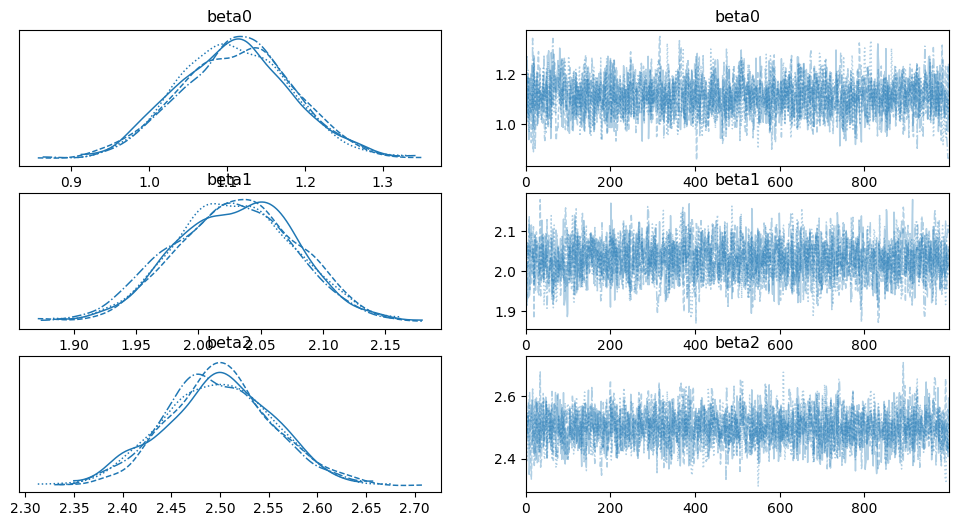

In [7]:
with manual_logistic_model:
    trace = pm.sample(1000, tune=1000, chains=4)

# Plotting the walk plots
pm.plot_trace(trace)

# Creating a table with HDI (Highest Density Interval)
summary = pm.summary(trace, hdi_prob=0.95)


In [8]:
summary


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta0,1.111,0.074,0.970,1.258,0.002,0.001,1740.0,1846.0,1.0
beta1,2.029,0.049,1.934,2.122,0.001,0.001,1801.0,1754.0,1.0
beta2,2.499,0.055,2.389,2.605,0.001,0.001,1742.0,1675.0,1.0


### 4. Bayesian Neural Network

We now implement a basic Bayesian Neural Network. That is a network that takes in our 2 inputs and a bias, aggregates them in a single neuron (through the linear combination $\beta X$) and then passes them through a sigmoid activation. That is, the output of the network is exactly $\sigma(\beta X) = p_i$. **However, now the weights are not deterministic but rather have prior distributions assinged to them. In each feed-forward step, the distribution is sampled to obtain $w_i$, and in each backwards pass the parameters of the priors are adjusted through gradient optimization**. In keeping with neural network convention, we define the following

- **A loss function**: We will define a custom loss function in order to use the **Evidence Lower Bound** as a loss. This loss is made up of a negative log likelihood term (which we understand as a **likelihood cost**) and a Kulback Leiber divergence term between a variational distribution and the priors (which we will call the **complexity cost**) That is, given a training tuple $(X,y)$, the network estimates  $\hat{p}=\sigma(\beta X)$ and then calculates the following loss: 

$$ L(D,\theta) = \pi KL(q(w|\theta) || p(w))) - \mathbb{E}_{q(w|\theta)}[log(p(D|w))] $$

We can rewrite the loss for all of it to be an expectation of the variational distribution:

$$ L(D,\theta) = \mathbb{E}_{q(w|\theta)}[ \log{q(w|\theta)} - \log{p(w)} - \log{p(D|w)}]$$


Since our loss is made up of an expectation, we must sample from our variational distribution to obtain $w_i$ that allows us to calculate the log likelihood. That is

$$ L(D,\theta) \approx \frac{1}{N} \sum_{i=1}^N [ \log{q(w_i|\theta)} - \log{p(w_i)} - \log{p(D|w_i)}]$$

- **An optimizer**: We use **Adam**, which is a variant of stochastic gradient descent using momentum

- **A number of epochs**: We train the network for 500 epochs, which would be similar to running a 500 sample MCMC chain


Additionally, the bayesian neural network requires us to specify a **variational distribution** that will approximate the posterior. As such, we opt for a multivariate Gaussian (in keeping with the selection in the previous example). That is, we let $\theta = (\alpha,\beta_1,\beta_2)$ such that $\theta \backsim N_3(\mu,\sigma I)$ , such that for each parameter we have $\mu_i$ and $\sigma_i$ which we will learn. By choosing a diagonal covariance matrix, we assume weight independence

In [9]:
# def prior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size
#     prior_model = tk.Sequential([
#         tfp.layers.DistributionLambda(lambda t : 
#         tfp.distributions.MultivariateNormalDiag(loc=tf.zeros(n), scale_diag=tf.ones(n))),
#     ])
#     return prior_model

X = np.column_stack((X1, X2))
#Our prior models every weight as an independent normal with mean 0 and standard deviation 1
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tk.Sequential([
        # tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: 
            tfp.distributions.Independent(
                tfp.distributions.Normal(loc=tf.zeros(n), scale=1),
                reinterpreted_batch_ndims=1))
    ])
    return prior_model
# def posterior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size
#     posterior_model = tk.Sequential([
#         tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
#         tfp.layers.MultivariateNormalTriL(n)
#     ])
#     return posterior_model

#The posterior also assumes independent normal distributions for each weight, but with learnable mu and sigma
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior_model = tk.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])
    return posterior_model

 

model = tk.Sequential([
    tfp.layers.DenseVariational(input_shape=(2, ), units=1, 
                          make_prior_fn=prior, make_posterior_fn=posterior, 
                        kl_weight=1/X.shape[0],
                          activation='sigmoid'
                           ),
])

def likelihood_cost(true_y,predicted_py):
    logprob = tfp.distributions.Bernoulli(probs=predicted_py).log_prob(true_y)
    loss = tf.reduce_mean(-logprob)
    return loss



# Compile the model
model.compile(optimizer='adam', loss=likelihood_cost, metrics=['accuracy'])



In [10]:
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVa  (None, 1)                 6         
 riational)                                                      
                                                                 
Total params: 6 (24.00 Byte)
Trainable params: 6 (24.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
dummy_input = X[1]
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)

print('Prior mean:     ', model_prior.mean().numpy())
print('Prior Variance: ', model_prior.variance().numpy())
print('Variational Posterior mean: ', model_posterior.mean().numpy())
print('Variational Posterior variance:', model_posterior.variance().numpy())

Prior mean:      [0. 0. 0.]
Prior Variance:  [1. 1. 1.]
Variational Posterior mean:  [0. 0. 0.]
Variational Posterior variance: [1.00002 1.00002 1.00002]


In [12]:
epochs = 100
model.fit(X,Y,epochs=epochs,verbose=0)

In [13]:
dummy_input = X[1]
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)

print('Prior mean:     ', model_prior.mean().numpy())
print('Prior Variance: ', model_prior.variance().numpy())
print('Variational Posterior mean: ', model_posterior.mean().numpy())
print('Variational Posterior variance:', model_posterior.variance().numpy())
print('Variational Posterior sd:',np.sqrt(model_posterior.variance().numpy()))


Prior mean:      [0. 0. 0.]
Prior Variance:  [1. 1. 1.]
Variational Posterior mean:  [2.021272  2.4798524 1.092769 ]
Variational Posterior variance: [0.00048258 0.00039162 0.00114735]
Variational Posterior sd: [0.02196775 0.01978935 0.03387249]


In [15]:
for i in range(3):
    media = model_posterior.mean().numpy()[i]
    sd = np.sqrt(model_posterior.variance().numpy())[i]
    print("IC")
    print([media - 1.96 * sd,media + 1.96 * sd])

IC
[1.9782151466608047, 2.064328741431236]
IC
[2.4410653206706048, 2.51863955527544]
IC
[1.0263789412379265, 1.1591591122746467]


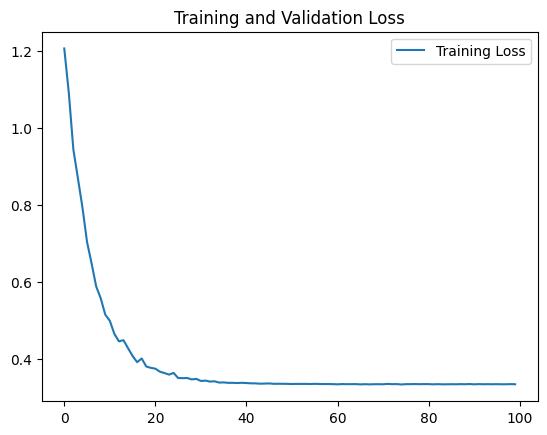

In [14]:
import matplotlib.pyplot as plt
loss = model.history.history["loss"]
epochs_range = range(epochs)

plt.plot(epochs_range,loss, label='Training Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()



In [43]:
L = b0 + b1 * X1 + b2 * X2
Y = np.random.poisson(np.exp(L))

X = np.column_stack((X1, X2))

#Our prior models every weight as an independent normal with mean 0 and standard deviation 1
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = tk.Sequential([
        # tfp.layers.VariableLayer(n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: 
            tfp.distributions.Independent(
                tfp.distributions.Normal(loc=tf.zeros(n), scale=1),
                reinterpreted_batch_ndims=1))
    ])
    return prior_model
# def posterior(kernel_size, bias_size, dtype=None):
#     n = kernel_size + bias_size
#     posterior_model = tk.Sequential([
#         tfp.layers.VariableLayer(tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype),
#         tfp.layers.MultivariateNormalTriL(n)
#     ])
#     return posterior_model

#The posterior also assumes independent normal distributions for each weight, but with learnable mu and sigma
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    posterior_model = tk.Sequential([
        tfp.layers.VariableLayer(2*n, dtype=dtype),
        tfp.layers.DistributionLambda(lambda t: tfp.distributions.Independent(
            tfp.distributions.Normal(loc=t[..., :n],
                       scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1)),
    ])
    return posterior_model

 

model = tk.Sequential([
    tfp.layers.DenseVariational(input_shape=(2, ), units=1, 
                          make_prior_fn=prior, make_posterior_fn=posterior, 
                        kl_weight=1/X.shape[0],
                          activation='exponential'
                           ),
])

def likelihood_cost(true_y,predicted_py):
    true_y = tf.cast(true_y, tf.float32)
    logprob = tfp.distributions.Poisson(rate=predicted_py).log_prob(true_y)
    loss = tf.reduce_mean(-logprob)
    return loss



# Compile the model
model.compile(optimizer='adam', loss=likelihood_cost, metrics=['accuracy'])



In [48]:
epochs = 1000
model.fit(X,Y,epochs=epochs,verbose=0)

In [49]:
dummy_input = X[1]
model_prior = model.layers[0]._prior(dummy_input)
model_posterior = model.layers[0]._posterior(dummy_input)

print('Prior mean:     ', model_prior.mean().numpy())
print('Prior Variance: ', model_prior.variance().numpy())
print('Variational Posterior mean: ', model_posterior.mean().numpy())
print('Variational Posterior variance:', model_posterior.variance().numpy())
print('Variational Posterior sd:',np.sqrt(model_posterior.variance().numpy()))



Prior mean:      [0. 0. 0.]
Prior Variance:  [1. 1. 1.]
Variational Posterior mean:  [1.9973222 2.399029  1.005596 ]
Variational Posterior variance: [3.4733077e-08 5.4415108e-07 4.8660553e-07]
Variational Posterior sd: [0.00018637 0.00073767 0.00069757]
